This is the same as the previous set of experiments, but with the MIP solve time limit doubled to 10s per MIQP and the optimality tolerance reduced from 10% to 1%. 

I also addressed an issue with the URDF in which the center of mass was 0.3m too low (and very close to the hip joints)

In [1]:
using Revise

In [2]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models

ArgumentError: Module Hiccup not found in current path.
Run `Pkg.add("Hiccup")` to install the Hiccup package.


In [3]:
robot = BoxAtlas()
mvis = MechanismVisualizer(robot)
IJuliaCell(mvis)

Listening on 127.0.0.1:7003...
zmq_url=tcp://127.0.0.1:6003
web_url=http://127.0.0.1:7003/static/


MeshCat.IJuliaCell(MeshCat.ViewerWindow(ZMQ.Context(Ptr{Void} @0x0000000006f6e1d0, WeakRef[WeakRef(ZMQ.Socket(Ptr{Void} @0x000000000721e1e0, Base.Filesystem._FDWatcher(Ptr{Void} @0x0000000007291b70, 78, (1, 0), Condition(Any[]), (false, false), 0)))]), ZMQ.Socket(Ptr{Void} @0x000000000721e1e0, Base.Filesystem._FDWatcher(Ptr{Void} @0x0000000007291b70, 78, (1, 0), Condition(Any[]), (false, false), 0)), "http://127.0.0.1:7003/static/", "tcp://127.0.0.1:6003", MeshCat.ZMQServer.ZMQWebSocketBridge(ip"127.0.0.1", Set{WebSockets.WebSocket}(), MeshCat.SceneTrees.SceneNode(Nullable{Array{UInt8,1}}(), Nullable{Array{UInt8,1}}(), Dict("meshcat"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0xa8, 0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74], Dict("world"=>MeshCat.SceneTrees.SceneNode(#NULL, #NULL, Dict("root"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x77, 0x6f, 0x72, 0x6c, 0x64, 0x2f, 0x72, 0x6f, 0x6f, 0x74], Dict("floor"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x6f, 0x74, 0x2f, 0x66, 0x6c, 0x6f, 0x6f, 0x72], Dict("wall"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x6c, 0x6f, 0x6f, 0x72, 0x2f, 0x77, 0x61, 0x6c, 0x6c], Dict("after_floor_to_wall"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x72, 0x5f, 0x74, 0x6f, 0x5f, 0x77, 0x61, 0x6c, 0x6c], Dict("geometry_2"=>MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], Dict{String,MeshCat.SceneTrees.SceneNode}()))))),"after_root_to_floor"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x5f, 0x74, 0x6f, 0x5f, 0x66, 0x6c, 0x6f, 0x6f, 0x72], Dict("geometry_1"=>MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31], Dict{String,MeshCat.SceneTrees.SceneNode}()))))),"floating_base_dummy"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x62, 0x61, 0x73, 0x65, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79], Dict("pelvis"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6d, 0x6d, 0x79, 0x2f, 0x70, 0x65, 0x6c, 0x76, 0x69, 0x73], Dict("after_floating_base_dummy_to_pelvis"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x74, 0x6f, 0x5f, 0x70, 0x65, 0x6c, 0x76, 0x69, 0x73], Dict("geometry_3"=>MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], Dict{String,MeshCat.SceneTrees.SceneNode}()))),"l_hand_mount_dummy"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x75, 0x6e, 0x74, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79], Dict("l_hand_mount"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0x61, 0x6e, 0x64, 0x5f, 0x6d, 0x6f, 0x75, 0x6e, 0x74], Dict("after_pelvis_to_l_hand_mount_extension"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x65, 0x78, 0x74, 0x65, 0x6e, 0

In [4]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params, false)
net, loss = LearningMPC.interval_net([22, 128, 128, 1])
optimizer = Flux.ADAM(Flux.params(net))

net_cost = LearningMPC.LearnedCost(lqrsol, net)

net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_mpc_controller]);

lqr_mpc_controller = MPCController(robot, (p = MPCParams(robot); p.horizon=1; p), lqrsol, [lqrsol])

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(::MPCController) (generic function with 1 method)

In [5]:
sample_sink = LearningMPC.MPCSampleSink{Float64}(true)
playback_sink = LearningMPC.PlaybackSink(mvis, params.Δt)

full_mpc_controller.callback = LearningMPC.call_each(
    sample_sink,
#     playback_sink,
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.call_each(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_mpc_controller,
        0.2),
    live_viewer
    )

dataset = LearningMPC.Dataset(lqrsol)

x_init = nominal_state(robot)

function collect_into!(data::Vector{<:LearningMPC.Sample}, σv=1.0)
    empty!(sample_sink)
    LearningMPC.randomize!(x0, x_init, 0.0, σv)
    results = LCPSim.simulate(x0, 
        dagger_controller,
        robot.environment, params.Δt, 100, 
        params.lcp_solver;
        termination=x -> configuration(x)[3] > π/4 || configuration(x)[3] < -π/4);
    append!(data, sample_sink.samples)
end

x0 = MechanismState{Float64}(robot.mechanism)

features(s::LearningMPC.Sample) = (s.state, s.mip.objective_bound, s.mip.objective_value)

features (generic function with 1 method)

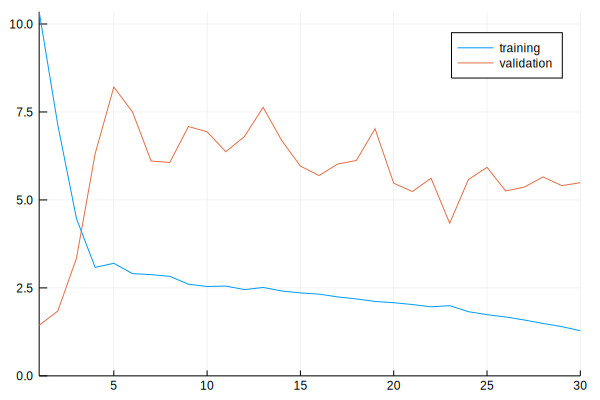

  2.799030 seconds (1.34 M allocations: 92.180 MiB, 2.08% gc time)


Progress:   1%|                                         |  ETA: 22:09:01

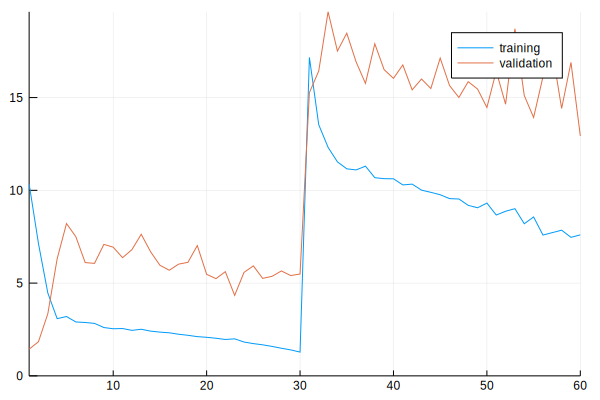

  2.004240 seconds (748.08 k allocations: 106.023 MiB, 1.54% gc time)


Progress:   2%|█                                        |  ETA: 1 days, 0:26:42

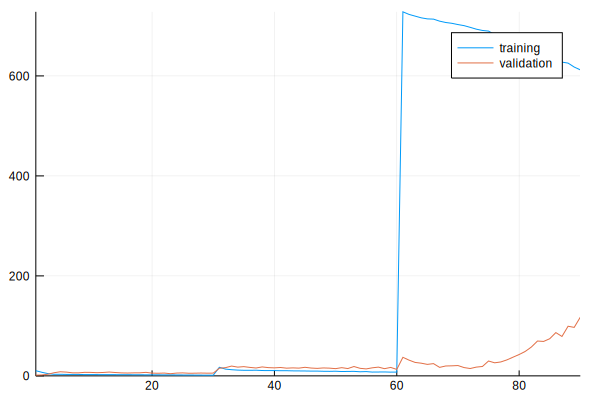

  4.469516 seconds (1.40 M allocations: 196.349 MiB, 1.41% gc time)


Progress:   3%|█                                        |  ETA: 1 days, 2:24:36

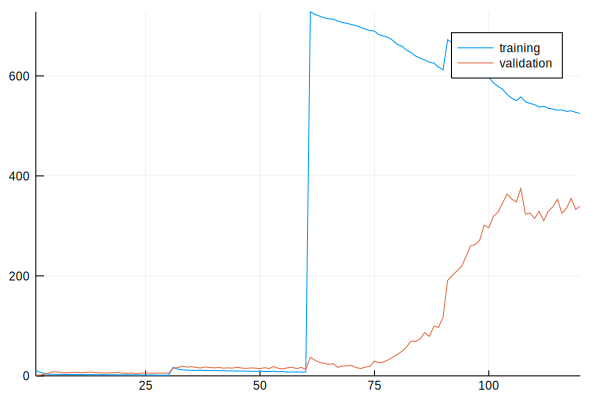

  4.511728 seconds (1.65 M allocations: 231.684 MiB, 1.48% gc time)


Progress:   4%|██                                       |  ETA: 22:39:26

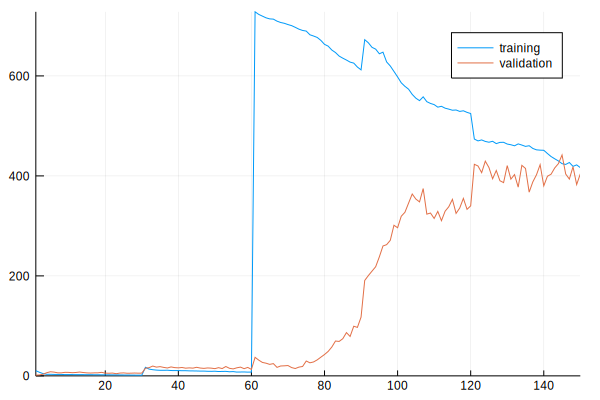

  5.988138 seconds (1.97 M allocations: 277.155 MiB, 1.75% gc time)


Progress:   5%|██                                       |  ETA: 20:32:21

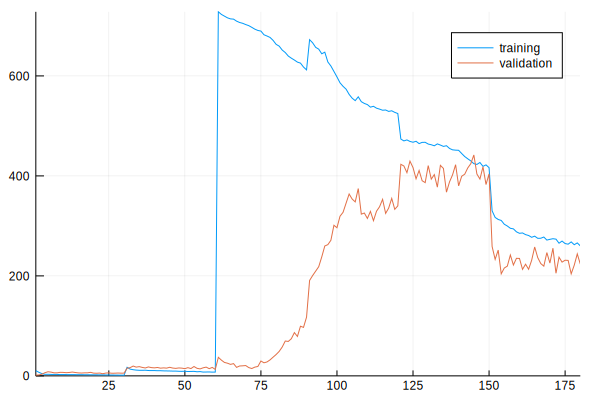

  8.683871 seconds (2.85 M allocations: 399.868 MiB, 1.65% gc time)


Progress:   6%|██                                       |  ETA: 22:51:56

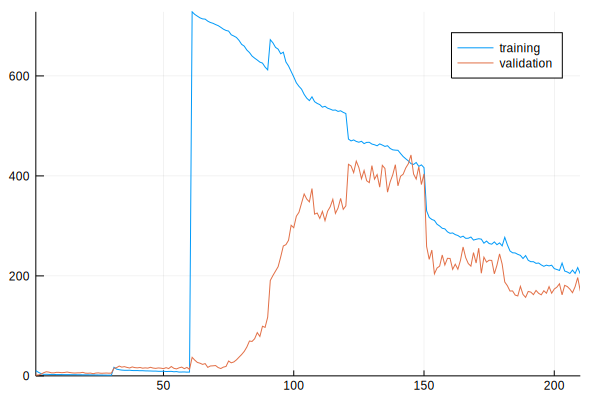

  9.818351 seconds (3.30 M allocations: 462.549 MiB, 1.92% gc time)


Progress:   7%|███                                      |  ETA: 22:55:14

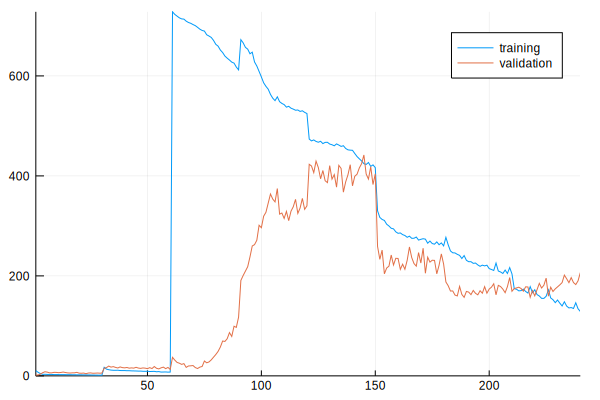

 10.805213 seconds (3.85 M allocations: 538.908 MiB, 2.32% gc time)


Progress:   8%|███                                      |  ETA: 22:36:21

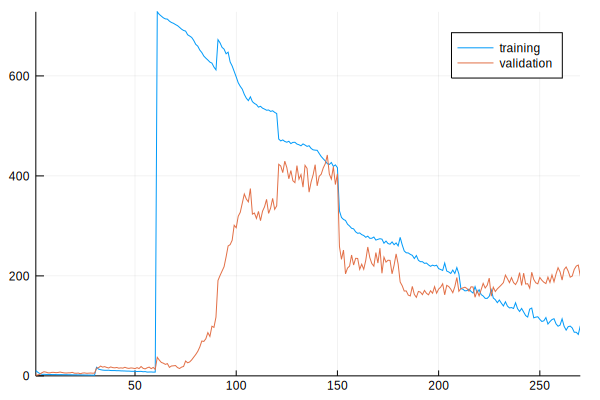

 11.946795 seconds (4.14 M allocations: 578.444 MiB, 1.46% gc time)


Progress:   9%|████                                     |  ETA: 21:19:35

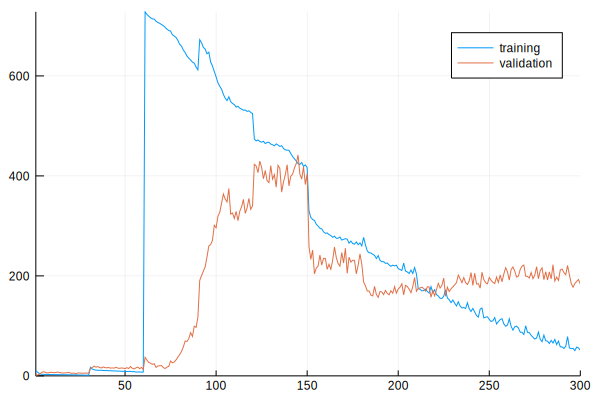

 13.077273 seconds (4.68 M allocations: 653.046 MiB, 2.10% gc time)


Progress:  10%|████                                     |  ETA: 20:48:11

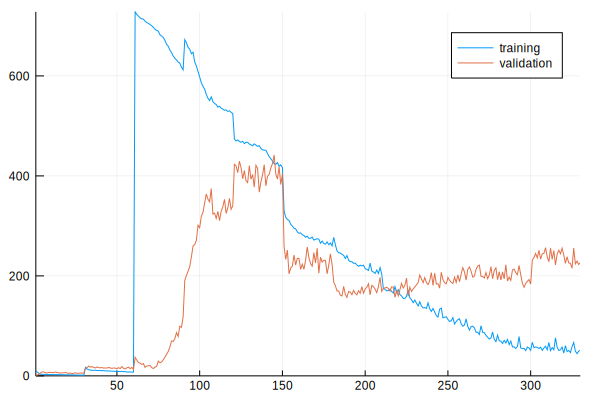

 14.536291 seconds (5.37 M allocations: 749.032 MiB, 1.75% gc time)


Progress:  11%|█████                                    |  ETA: 21:00:37

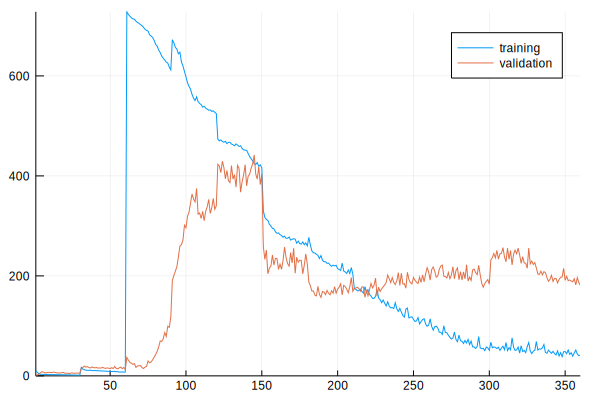

 16.549095 seconds (6.03 M allocations: 840.856 MiB, 1.40% gc time)


Progress:  12%|█████                                    |  ETA: 21:12:26

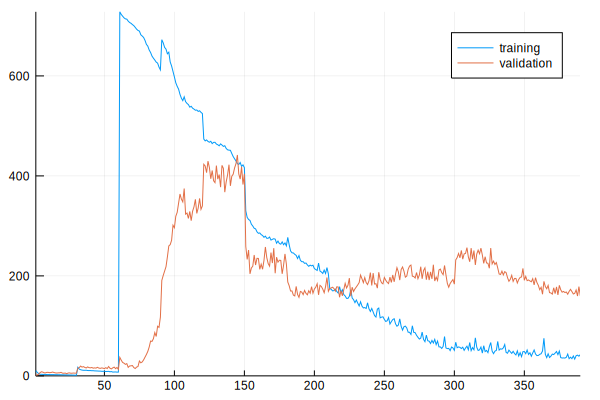

 19.326005 seconds (6.48 M allocations: 903.813 MiB, 1.88% gc time)


Progress:  13%|█████                                    |  ETA: 21:14:41

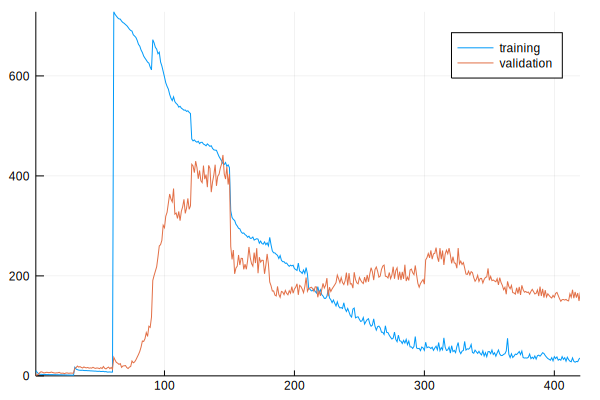

 19.966922 seconds (7.22 M allocations: 1006.627 MiB, 1.58% gc time)


Progress:  14%|██████                                   |  ETA: 21:32:22

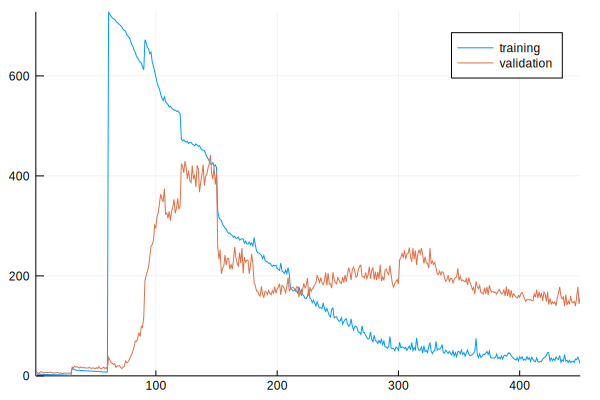

 22.915629 seconds (7.83 M allocations: 1.067 GiB, 2.06% gc time)


Progress:  15%|██████                                   |  ETA: 21:32:08

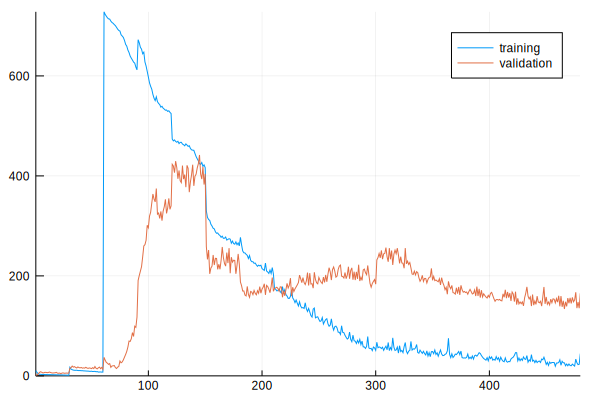

 24.901630 seconds (8.17 M allocations: 1.113 GiB, 1.46% gc time)


Progress:  16%|███████                                  |  ETA: 21:00:05

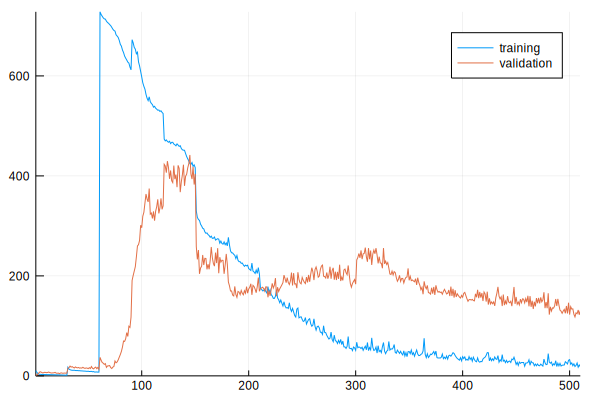

 26.413996 seconds (8.56 M allocations: 1.168 GiB, 1.29% gc time)


Progress:  17%|███████                                  |  ETA: 20:37:42

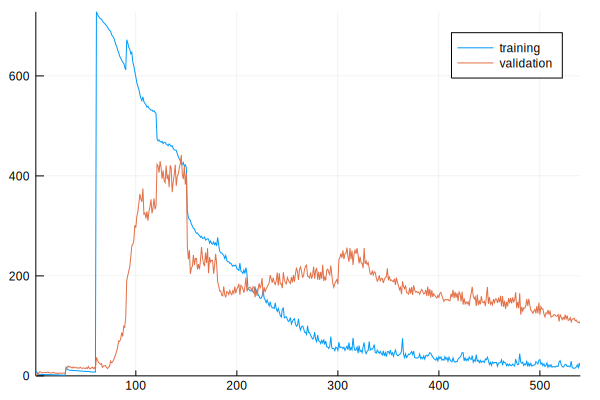

 24.182731 seconds (9.05 M allocations: 1.235 GiB, 2.12% gc time)


Progress:  18%|███████                                  |  ETA: 20:24:30

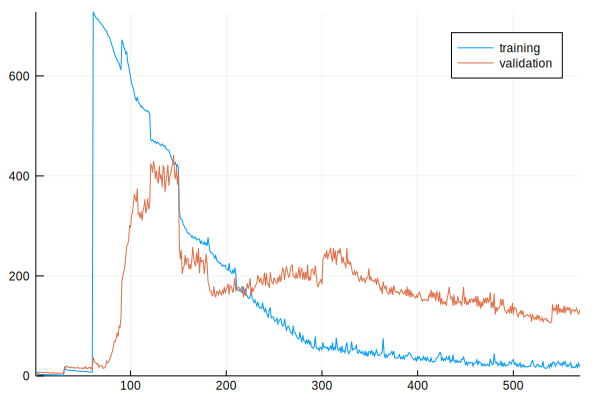

 26.714954 seconds (9.39 M allocations: 1.282 GiB, 2.16% gc time)


Progress:  19%|████████                                 |  ETA: 20:04:33

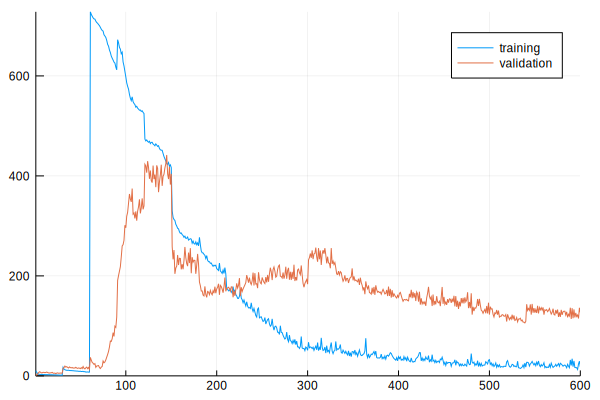

 31.301340 seconds (10.16 M allocations: 1.385 GiB, 1.50% gc time)


Progress:  20%|████████                                 |  ETA: 20:09:38

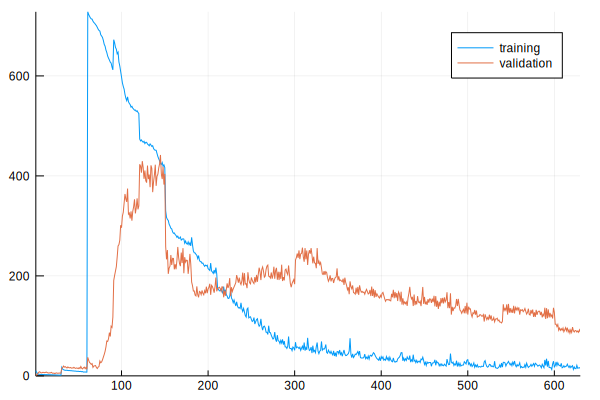

 35.059403 seconds (11.01 M allocations: 1.501 GiB, 2.06% gc time)


Progress:  21%|█████████                                |  ETA: 20:24:18

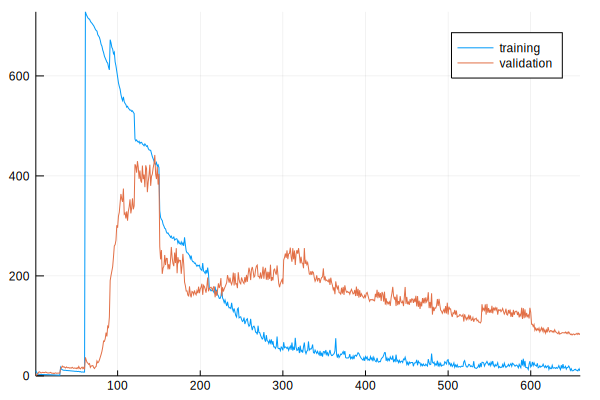

 35.305337 seconds (11.85 M allocations: 1.613 GiB, 2.05% gc time)


Progress:  22%|█████████                                |  ETA: 20:21:10

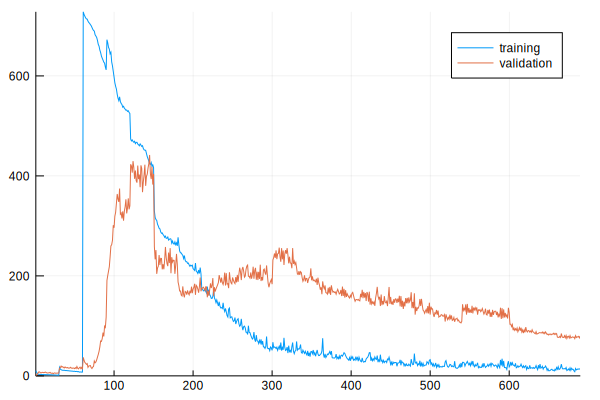

 35.181521 seconds (12.63 M allocations: 1.719 GiB, 1.88% gc time)


Progress:  23%|█████████                                |  ETA: 20:23:06

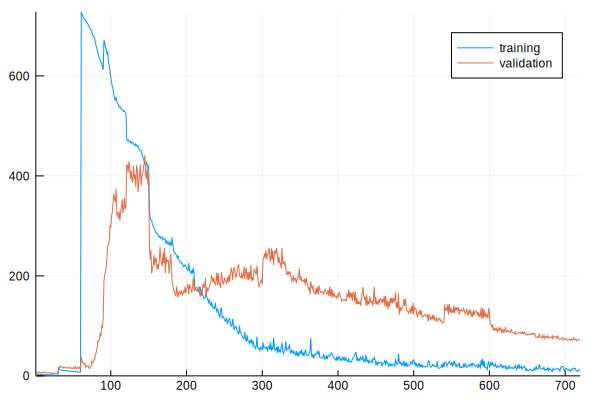

 44.084645 seconds (13.36 M allocations: 1.818 GiB, 1.67% gc time)


Progress:  24%|██████████                               |  ETA: 20:23:16

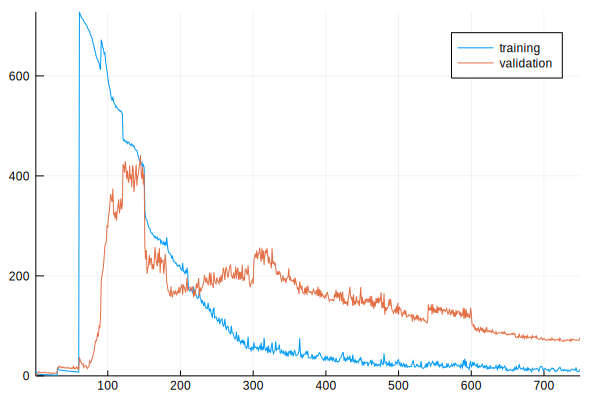

 40.869406 seconds (14.20 M allocations: 1.932 GiB, 2.09% gc time)


Progress:  25%|██████████                               |  ETA: 20:18:36

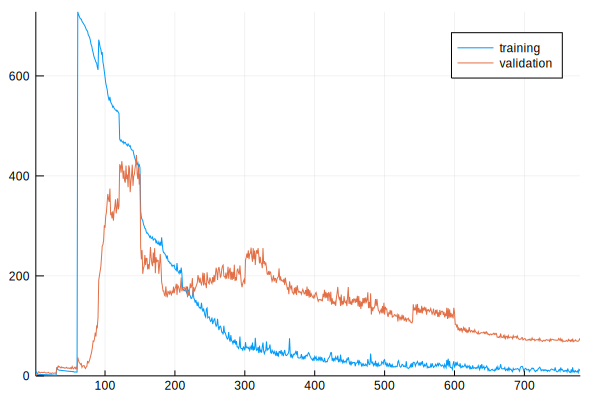

 41.490737 seconds (15.00 M allocations: 2.040 GiB, 2.12% gc time)


Progress:  26%|███████████                              |  ETA: 20:14:08

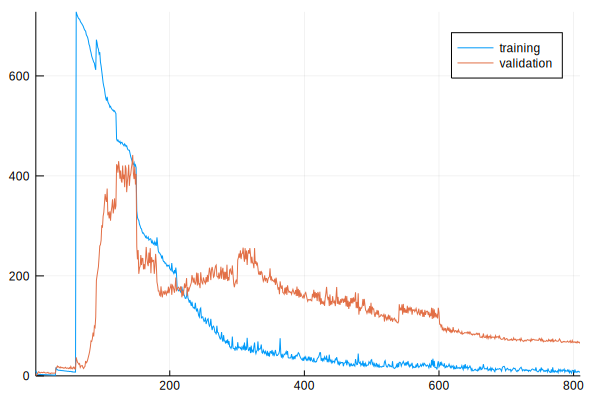

 44.306703 seconds (15.85 M allocations: 2.154 GiB, 2.00% gc time)


Progress:  27%|███████████                              |  ETA: 20:11:07

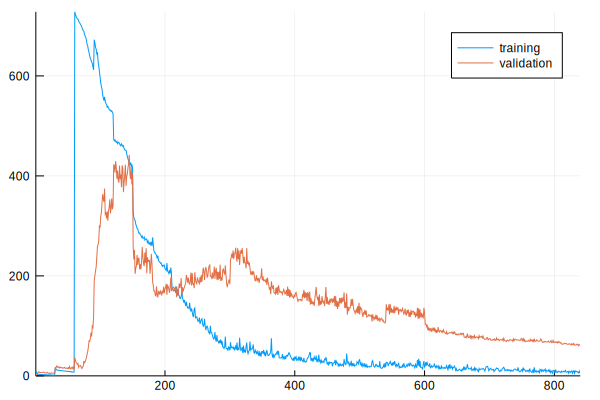

 49.005721 seconds (16.48 M allocations: 2.240 GiB, 1.39% gc time)


Progress:  28%|███████████                              |  ETA: 19:56:39

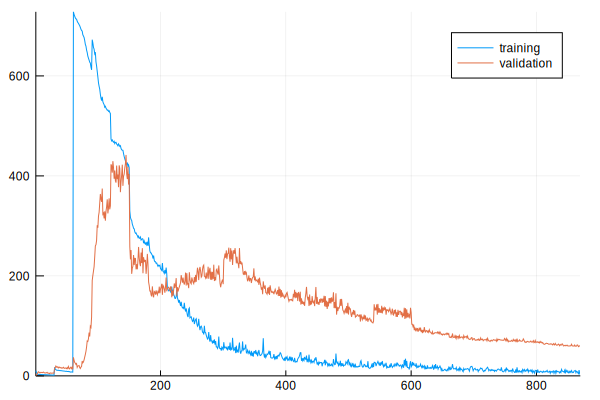

 47.175024 seconds (16.97 M allocations: 2.307 GiB, 1.97% gc time)


Progress:  29%|████████████                             |  ETA: 19:37:03

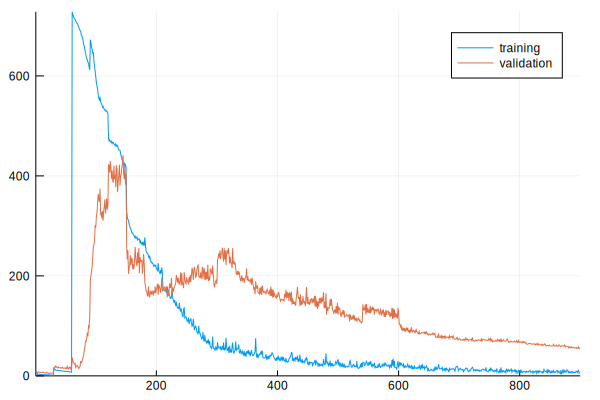

 52.507037 seconds (17.68 M allocations: 2.402 GiB, 2.17% gc time)


Progress:  30%|████████████                             |  ETA: 19:27:34

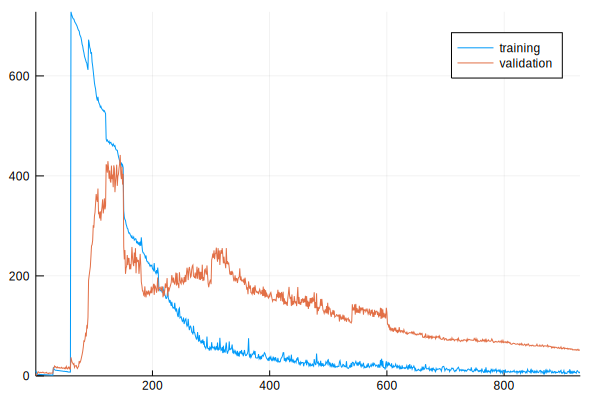

 50.739502 seconds (18.38 M allocations: 2.497 GiB, 2.12% gc time)


Progress:  31%|█████████████                            |  ETA: 19:15:34

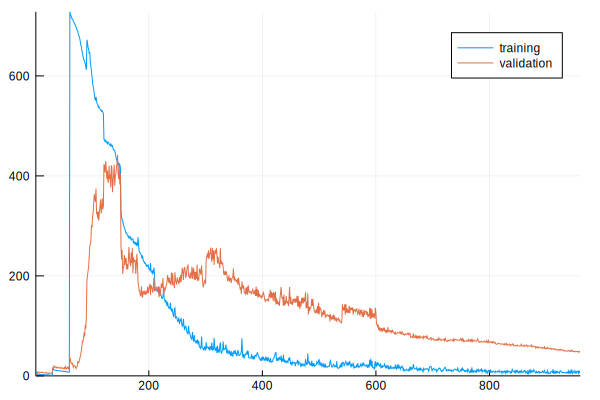

 51.950761 seconds (19.10 M allocations: 2.595 GiB, 2.13% gc time)


Progress:  32%|█████████████                            |  ETA: 19:04:40

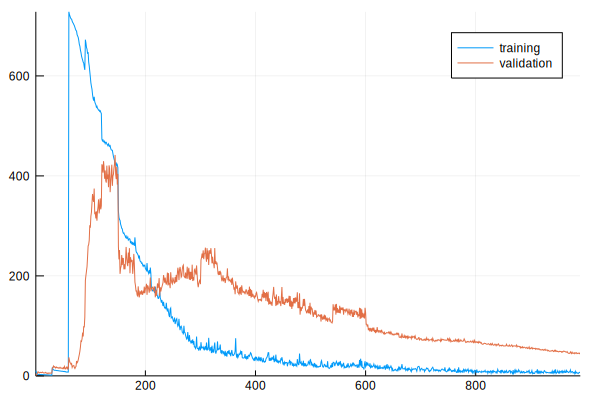

 54.273456 seconds (19.87 M allocations: 2.699 GiB, 2.19% gc time)


Progress:  33%|██████████████                           |  ETA: 18:51:43

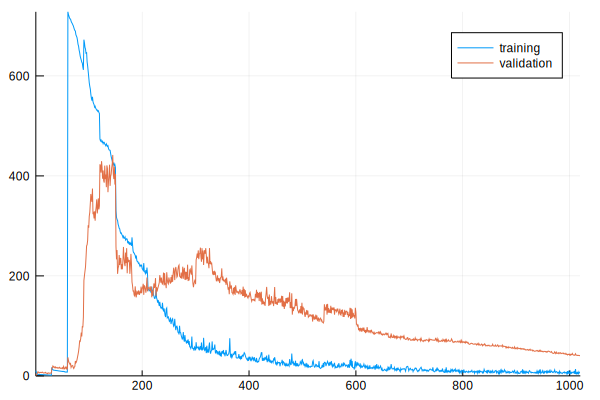

 56.951784 seconds (20.76 M allocations: 2.819 GiB, 1.53% gc time)


Progress:  34%|██████████████                           |  ETA: 18:44:32

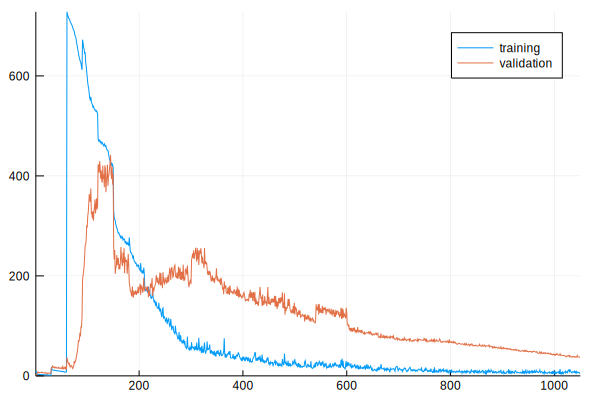

 60.375418 seconds (21.70 M allocations: 2.945 GiB, 1.65% gc time)


Progress:  35%|██████████████                           |  ETA: 18:35:55

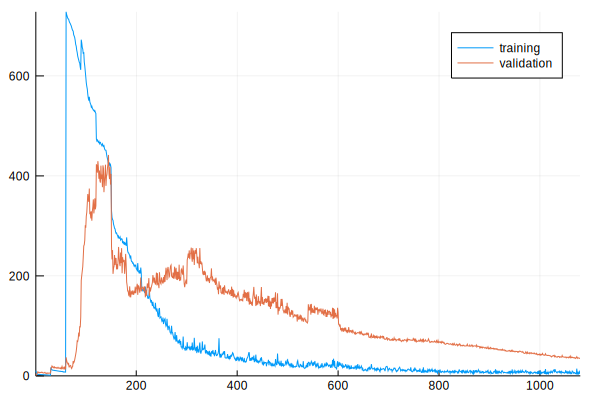

 61.575577 seconds (22.34 M allocations: 3.032 GiB, 1.90% gc time)


Progress:  36%|███████████████                          |  ETA: 18:18:48

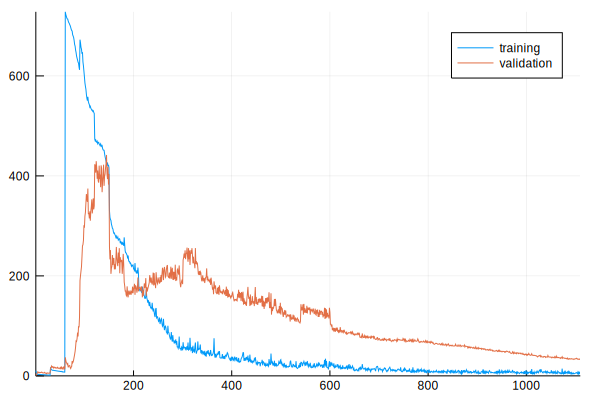

 61.548605 seconds (22.81 M allocations: 3.098 GiB, 1.91% gc time)


Progress:  37%|███████████████                          |  ETA: 18:00:03

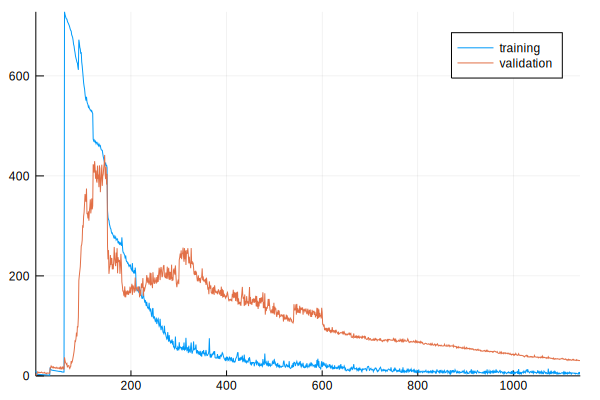

 64.034171 seconds (23.69 M allocations: 3.217 GiB, 1.92% gc time)


Progress:  38%|████████████████                         |  ETA: 17:53:16

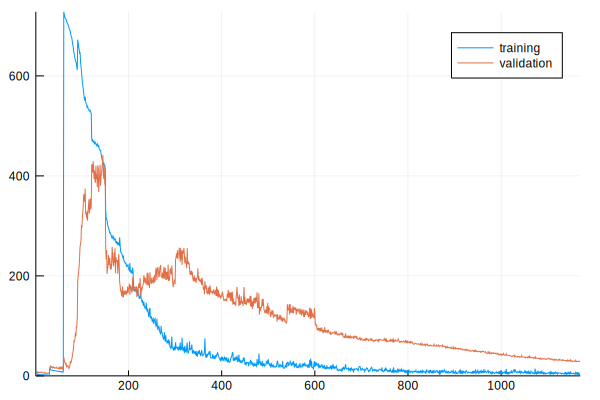

 66.628772 seconds (24.61 M allocations: 3.342 GiB, 1.61% gc time)


Progress:  39%|████████████████                         |  ETA: 17:45:49

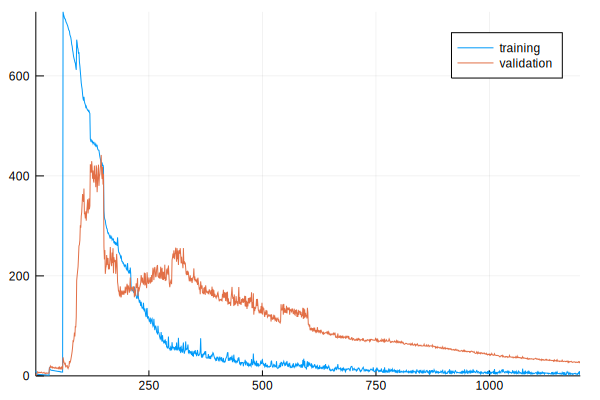

 69.566910 seconds (25.42 M allocations: 3.451 GiB, 2.14% gc time)


Progress:  40%|████████████████                         |  ETA: 17:32:41

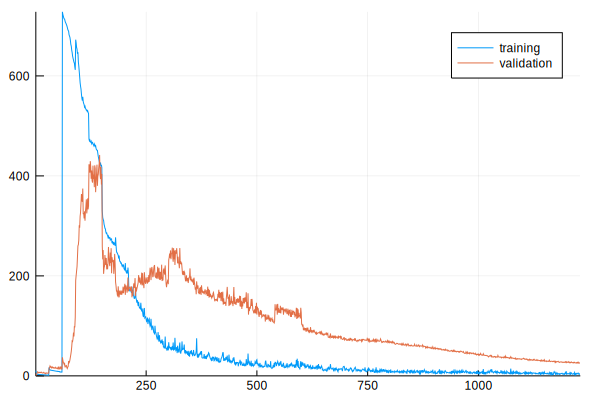

 70.997502 seconds (26.26 M allocations: 3.565 GiB, 1.47% gc time)


Progress:  41%|█████████████████                        |  ETA: 17:19:11

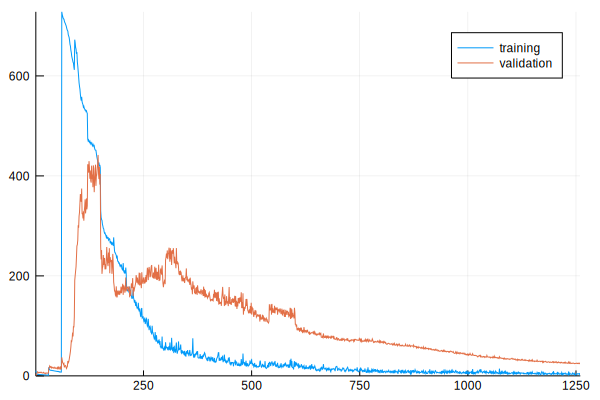

 73.140726 seconds (26.89 M allocations: 3.649 GiB, 1.43% gc time)


Progress:  42%|█████████████████                        |  ETA: 17:00:33

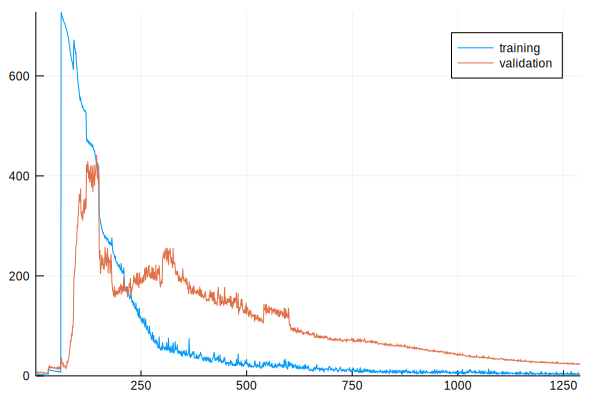

 75.766471 seconds (27.55 M allocations: 3.740 GiB, 2.10% gc time)


Progress:  43%|██████████████████                       |  ETA: 16:46:34

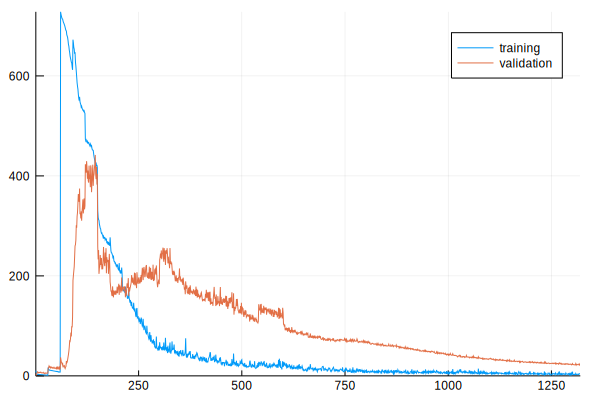

 77.441836 seconds (28.08 M allocations: 3.811 GiB, 2.11% gc time)


Progress:  44%|██████████████████                       |  ETA: 16:25:39

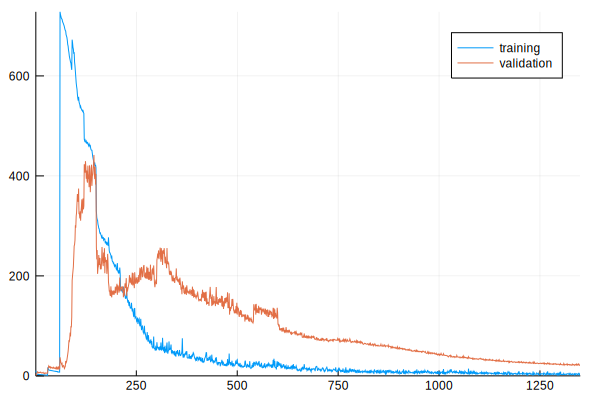

 78.346489 seconds (28.87 M allocations: 3.918 GiB, 2.10% gc time)


Progress:  45%|██████████████████                       |  ETA: 16:10:18

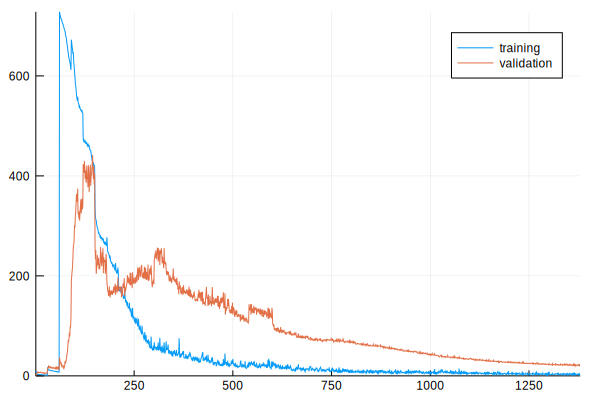

 82.475863 seconds (29.72 M allocations: 4.033 GiB, 1.93% gc time)


Progress:  46%|███████████████████                      |  ETA: 15:56:45

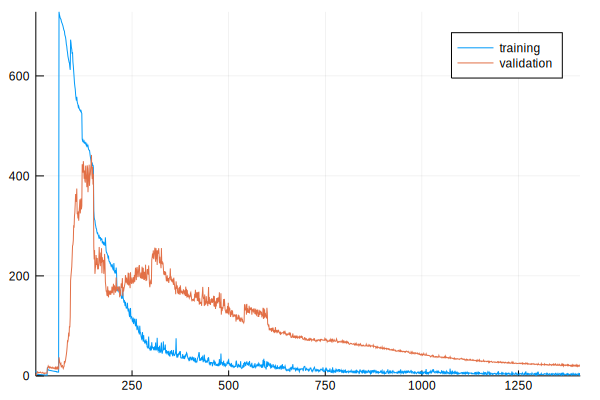

 80.692880 seconds (30.52 M allocations: 4.141 GiB, 1.46% gc time)


Progress:  47%|███████████████████                      |  ETA: 15:42:54

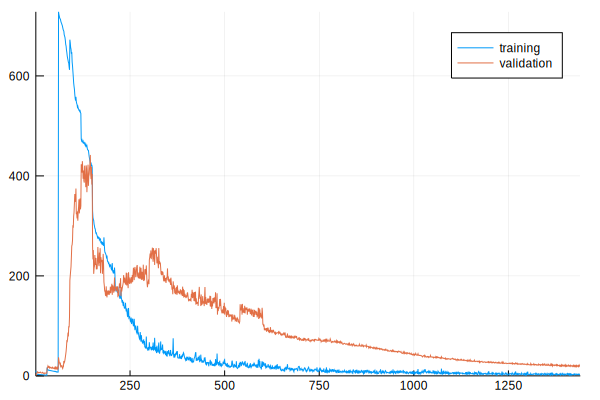

 81.699876 seconds (31.11 M allocations: 4.221 GiB, 1.45% gc time)


Progress:  48%|████████████████████                     |  ETA: 15:24:24

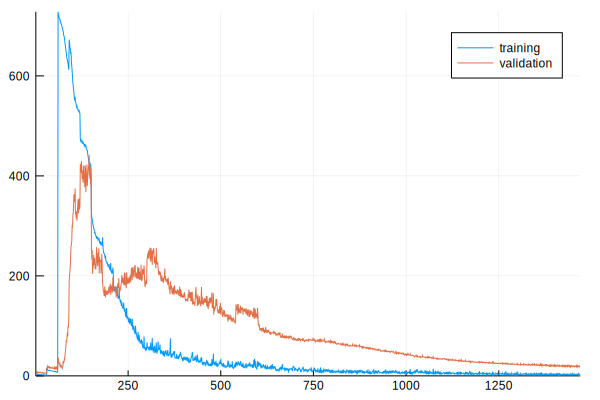

 85.292558 seconds (31.79 M allocations: 4.312 GiB, 2.04% gc time)


Progress:  49%|████████████████████                     |  ETA: 15:07:30

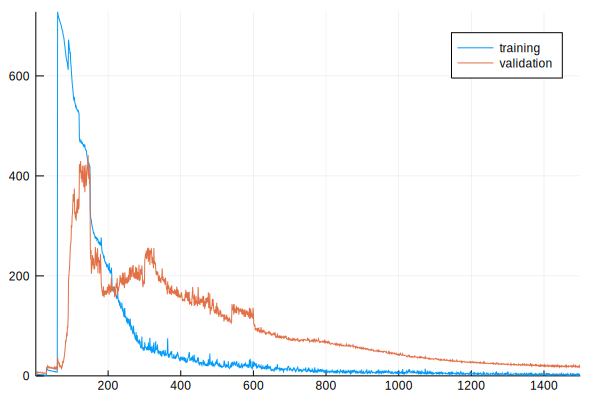

 89.603436 seconds (32.67 M allocations: 4.431 GiB, 2.03% gc time)


Progress:  50%|████████████████████                     |  ETA: 14:53:43

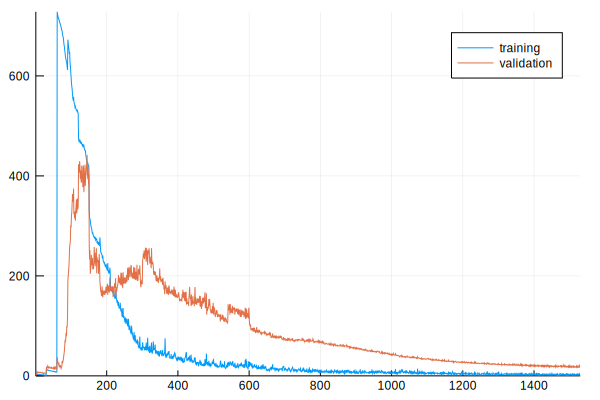

 91.678861 seconds (33.38 M allocations: 4.528 GiB, 1.81% gc time)


Progress:  51%|█████████████████████                    |  ETA: 14:39:47

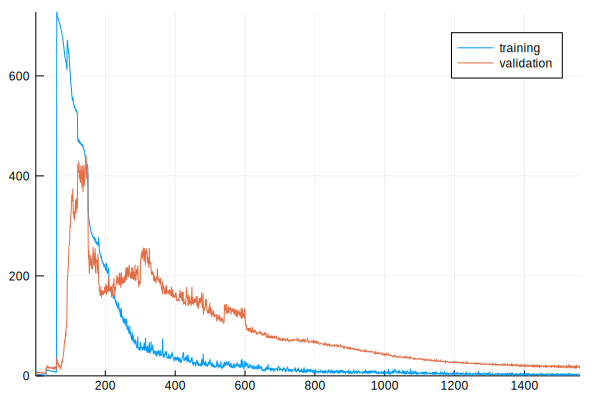

 92.802598 seconds (34.22 M allocations: 4.643 GiB, 2.24% gc time)


Progress:  52%|█████████████████████                    |  ETA: 14:26:08

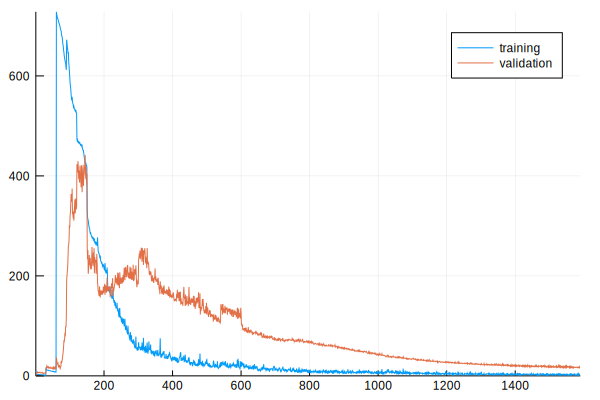

 92.410634 seconds (35.00 M allocations: 4.748 GiB, 1.55% gc time)


Progress:  53%|██████████████████████                   |  ETA: 14:10:35

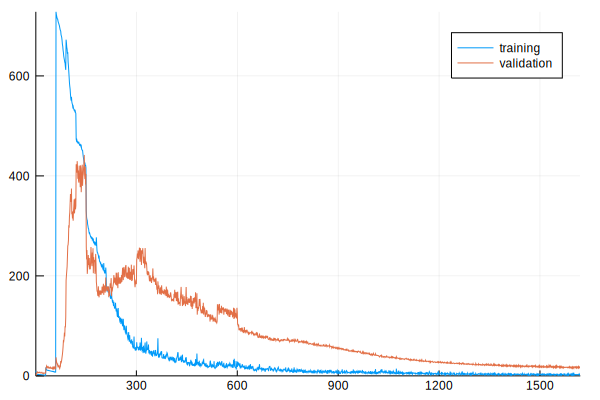

 95.911033 seconds (35.82 M allocations: 4.859 GiB, 2.20% gc time)


Progress:  54%|██████████████████████                   |  ETA: 13:54:59

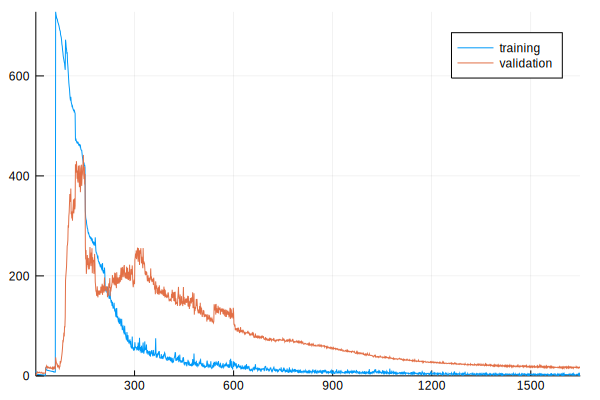

100.111396 seconds (36.57 M allocations: 4.961 GiB, 2.13% gc time)


Progress:  55%|███████████████████████                  |  ETA: 13:38:26

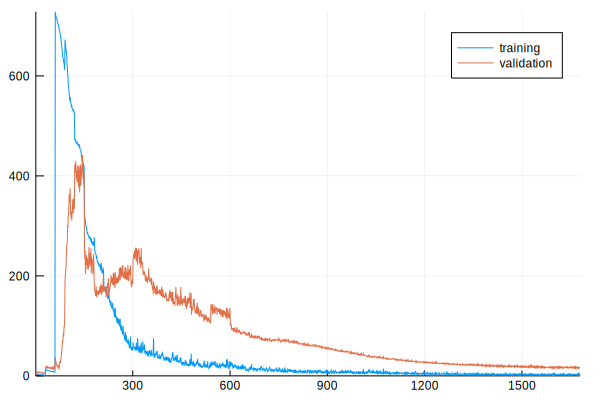

100.330729 seconds (37.20 M allocations: 5.046 GiB, 2.05% gc time)


Progress:  56%|███████████████████████                  |  ETA: 13:21:09

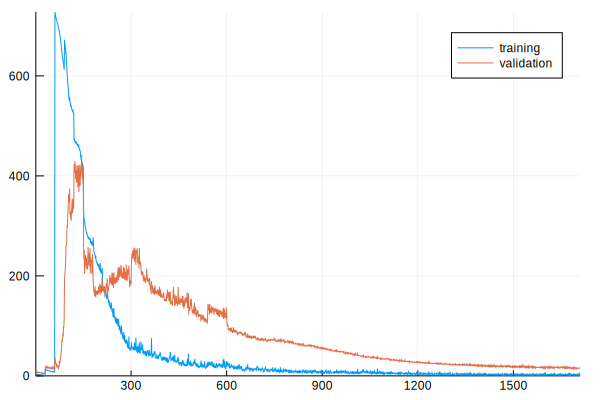

101.757676 seconds (37.94 M allocations: 5.147 GiB, 2.07% gc time)


Progress:  57%|███████████████████████                  |  ETA: 13:04:40

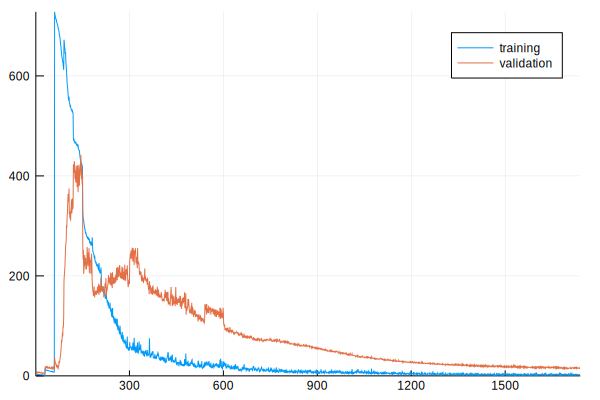

105.536847 seconds (38.79 M allocations: 5.262 GiB, 2.15% gc time)


Progress:  58%|████████████████████████                 |  ETA: 12:51:05

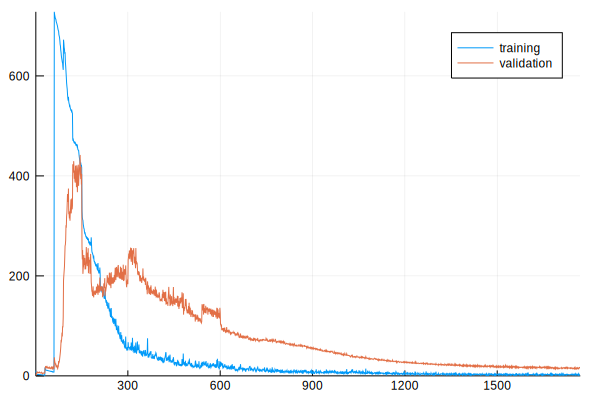

106.640986 seconds (39.60 M allocations: 5.372 GiB, 2.15% gc time)


Progress:  59%|████████████████████████                 |  ETA: 12:35:27

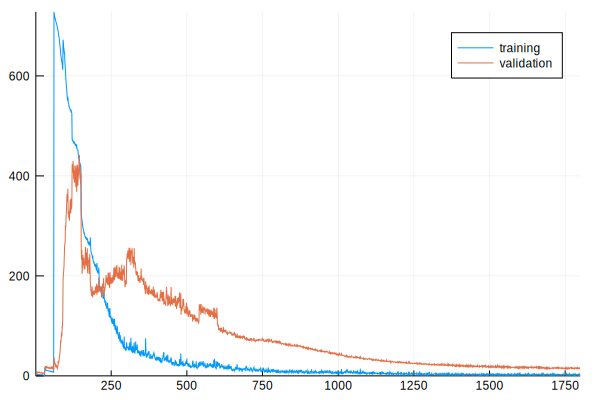

109.161408 seconds (40.29 M allocations: 5.466 GiB, 2.10% gc time)


Progress:  60%|█████████████████████████                |  ETA: 12:18:04

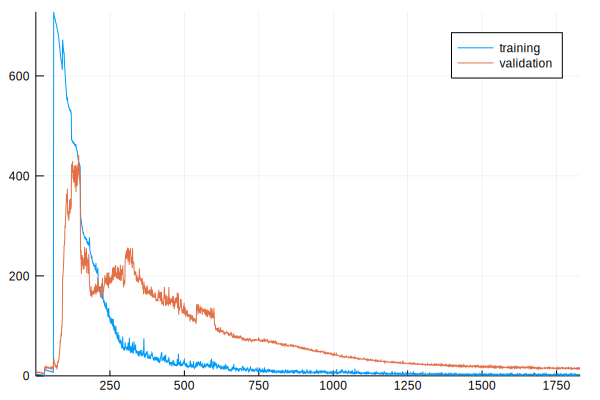

111.589539 seconds (40.98 M allocations: 5.559 GiB, 1.51% gc time)


Progress:  61%|█████████████████████████                |  ETA: 12:01:14

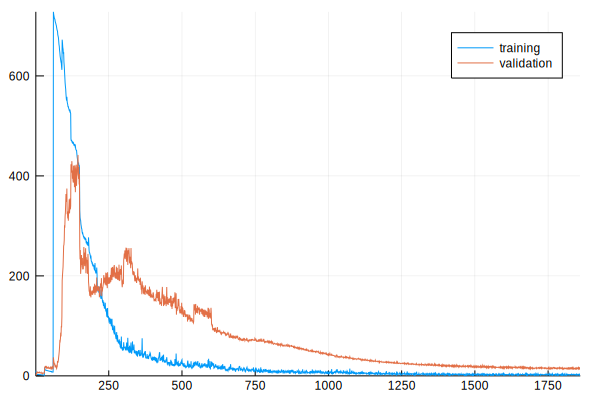

110.946840 seconds (41.54 M allocations: 5.636 GiB, 1.39% gc time)


Progress:  62%|█████████████████████████                |  ETA: 11:43:33

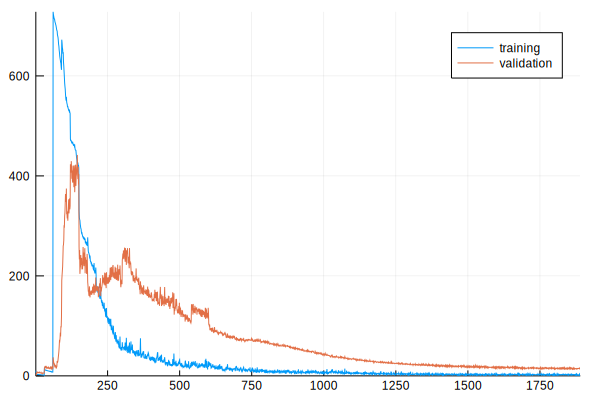

112.342678 seconds (42.19 M allocations: 5.724 GiB, 1.45% gc time)


Progress:  63%|██████████████████████████               |  ETA: 11:26:13

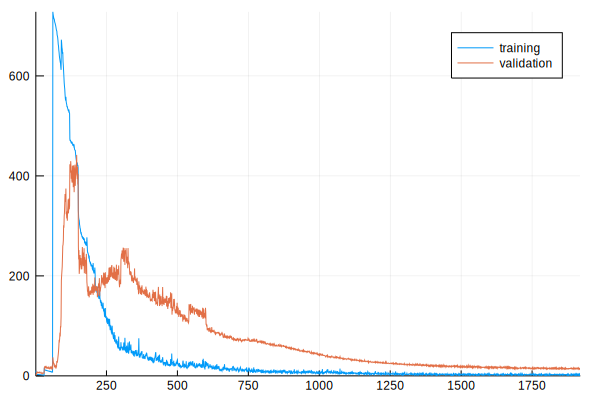

114.891138 seconds (43.00 M allocations: 5.834 GiB, 2.13% gc time)


Progress:  64%|██████████████████████████               |  ETA: 11:09:21

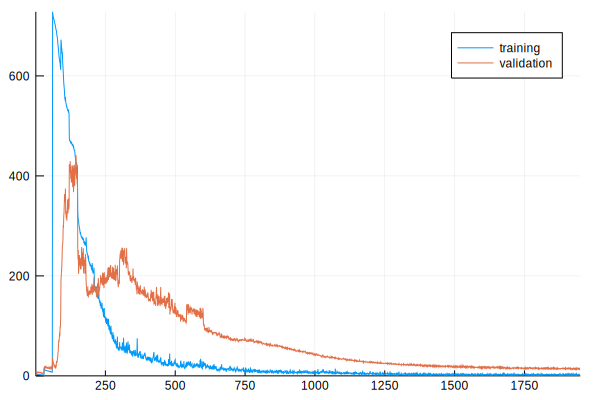

133.444821 seconds (43.49 M allocations: 5.902 GiB, 1.78% gc time)


Progress:  65%|███████████████████████████              |  ETA: 10:50:13

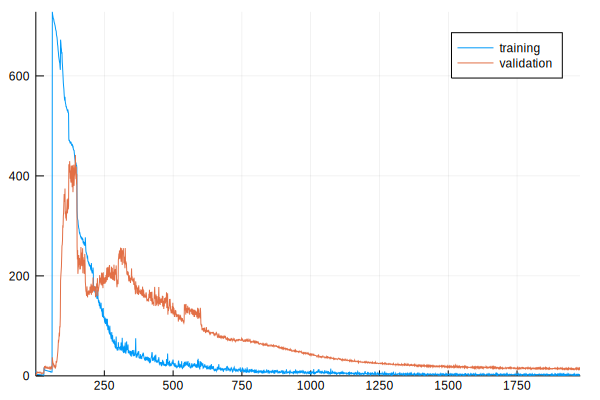

138.110751 seconds (44.00 M allocations: 5.971 GiB, 1.82% gc time)


Progress:  66%|███████████████████████████              |  ETA: 10:31:19

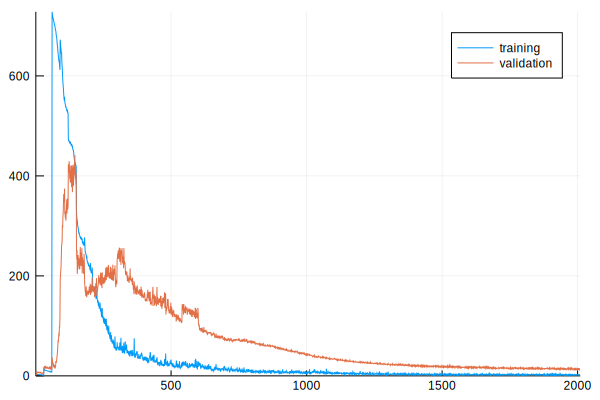

139.747594 seconds (44.57 M allocations: 6.049 GiB, 2.06% gc time)


Progress:  67%|███████████████████████████              |  ETA: 10:12:56

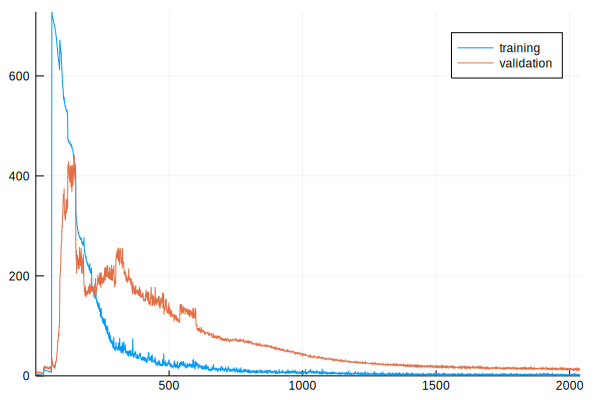

118.748237 seconds (45.39 M allocations: 6.160 GiB, 1.84% gc time)


Progress:  68%|████████████████████████████             |  ETA: 9:56:01

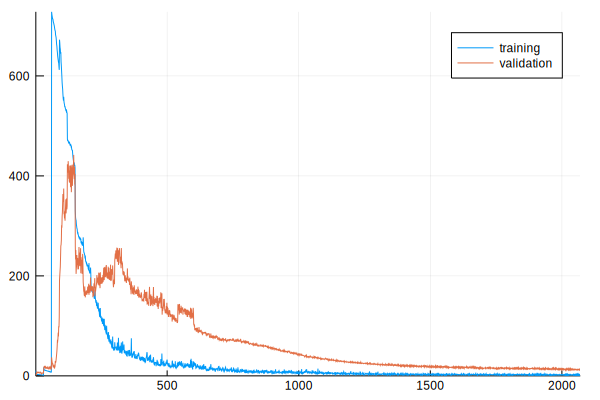

130.392109 seconds (46.12 M allocations: 6.259 GiB, 1.33% gc time)


Progress:  69%|████████████████████████████             |  ETA: 9:37:51

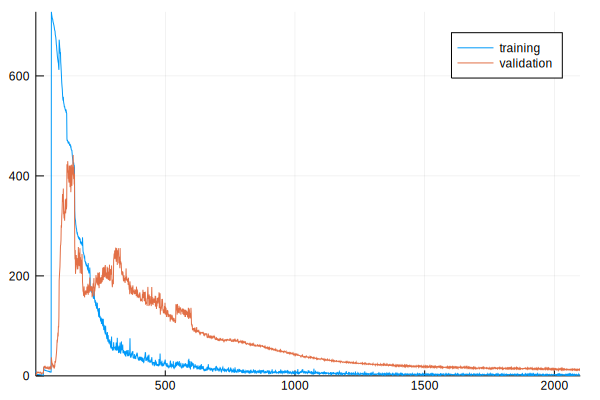

144.301138 seconds (46.69 M allocations: 6.336 GiB, 1.74% gc time)


Progress:  70%|█████████████████████████████            |  ETA: 9:19:31

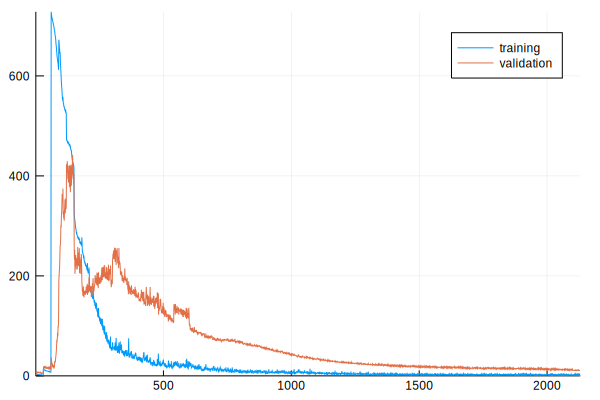

145.556199 seconds (47.34 M allocations: 6.424 GiB, 1.95% gc time)


Progress:  71%|█████████████████████████████            |  ETA: 9:01:57

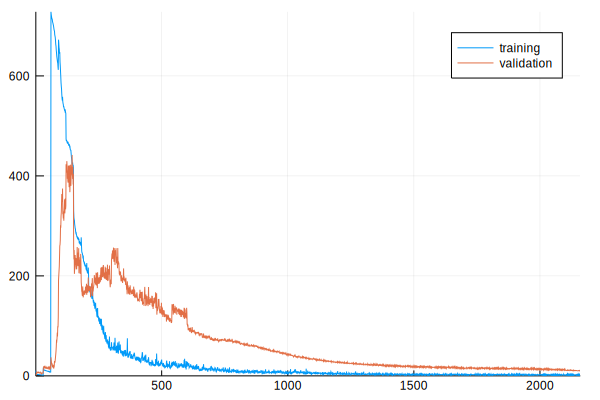

149.113454 seconds (48.09 M allocations: 6.525 GiB, 1.96% gc time)


Progress:  72%|██████████████████████████████           |  ETA: 8:45:09

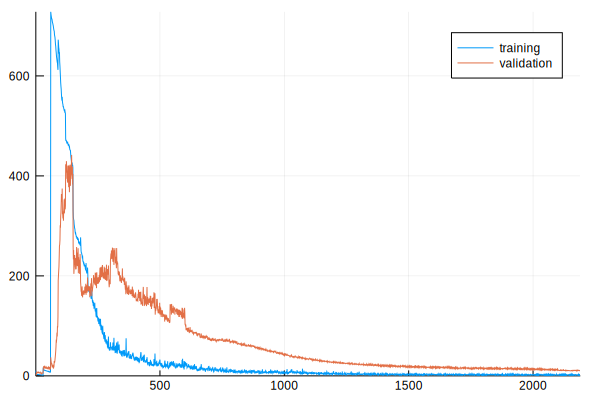

146.650455 seconds (48.96 M allocations: 6.643 GiB, 1.80% gc time)


Progress:  73%|██████████████████████████████           |  ETA: 8:28:08

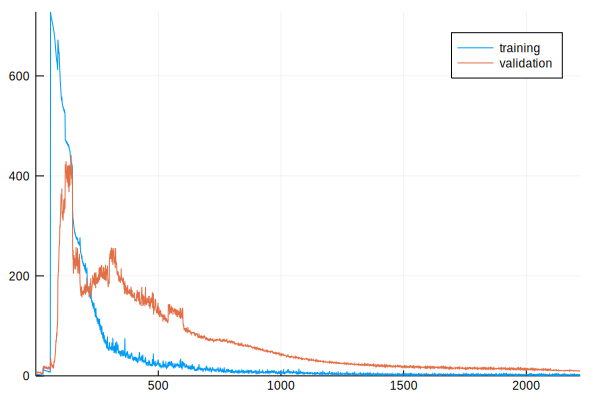

143.613286 seconds (49.60 M allocations: 6.729 GiB, 2.09% gc time)


Progress:  74%|██████████████████████████████           |  ETA: 8:09:27

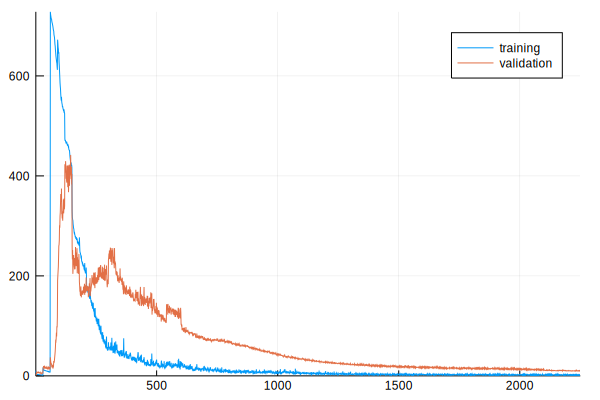

162.784443 seconds (50.28 M allocations: 6.823 GiB, 1.37% gc time)


Progress:  75%|███████████████████████████████          |  ETA: 7:51:51

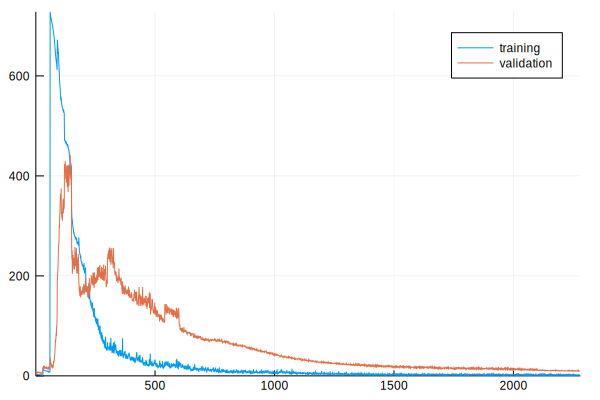

124.008227 seconds (51.19 M allocations: 6.945 GiB, 1.89% gc time)


Progress:  76%|███████████████████████████████          |  ETA: 7:34:32

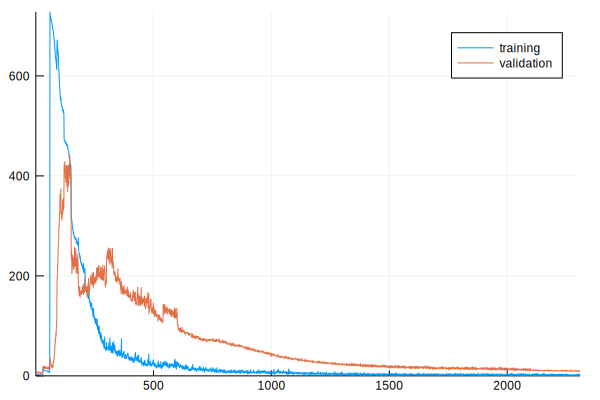

177.865554 seconds (52.07 M allocations: 7.064 GiB, 1.95% gc time)


Progress:  77%|████████████████████████████████         |  ETA: 7:17:31

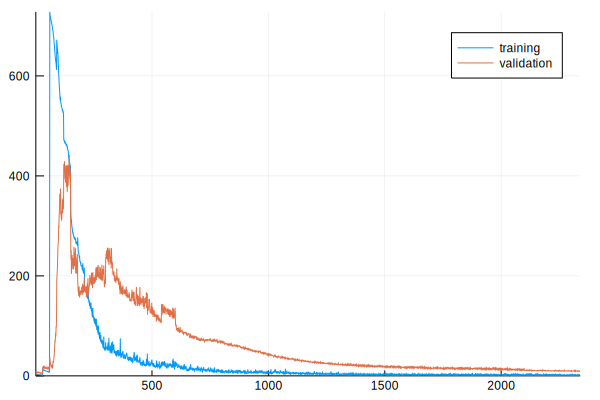

119.466553 seconds (52.60 M allocations: 7.136 GiB, 2.43% gc time)


Progress:  78%|████████████████████████████████         |  ETA: 6:58:41

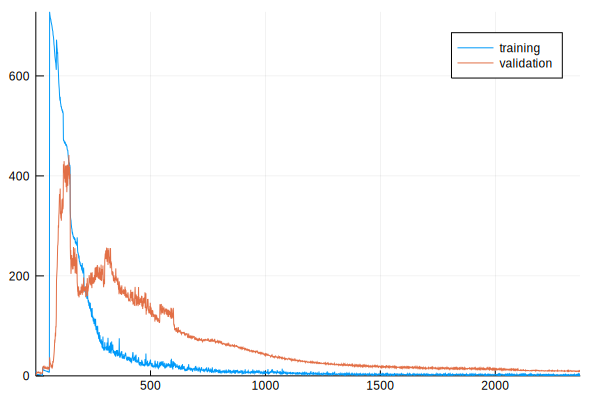

131.624147 seconds (53.20 M allocations: 7.219 GiB, 2.44% gc time)


Progress:  79%|████████████████████████████████         |  ETA: 6:40:09

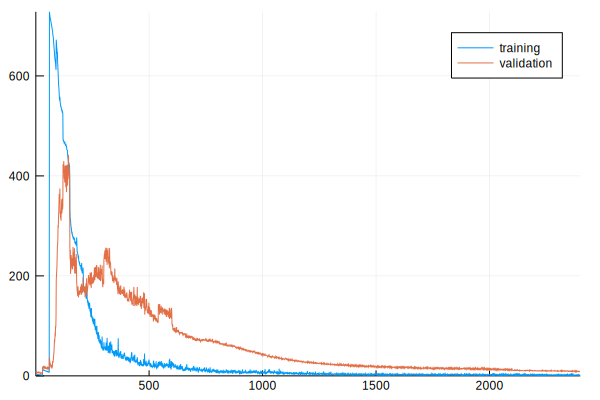

136.592857 seconds (54.05 M allocations: 7.333 GiB, 2.06% gc time)


Progress:  80%|█████████████████████████████████        |  ETA: 6:21:58

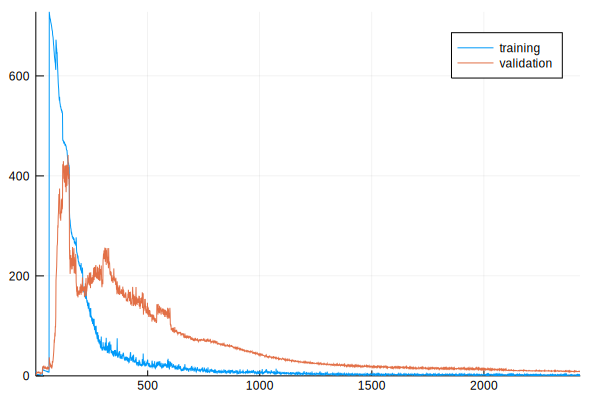

125.748492 seconds (54.84 M allocations: 7.440 GiB, 1.64% gc time)


Progress:  81%|█████████████████████████████████        |  ETA: 6:03:36

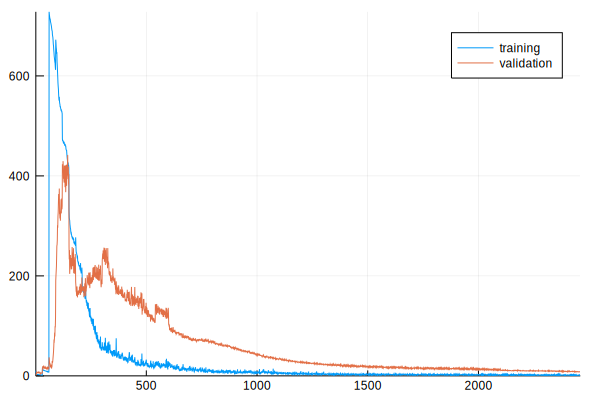

135.702329 seconds (55.66 M allocations: 7.552 GiB, 2.16% gc time)


Progress:  82%|██████████████████████████████████       |  ETA: 5:45:41

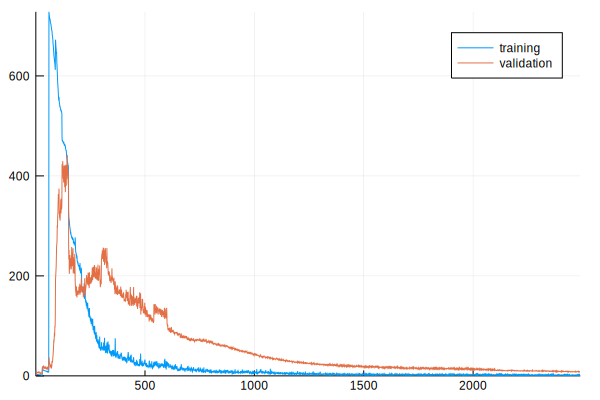

138.738157 seconds (56.35 M allocations: 7.646 GiB, 1.72% gc time)


Progress:  83%|██████████████████████████████████       |  ETA: 5:27:17

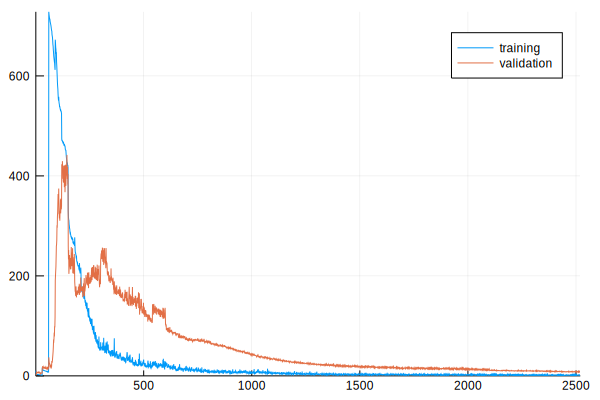

131.750085 seconds (57.08 M allocations: 7.744 GiB, 2.58% gc time)


Progress:  84%|██████████████████████████████████       |  ETA: 5:08:13

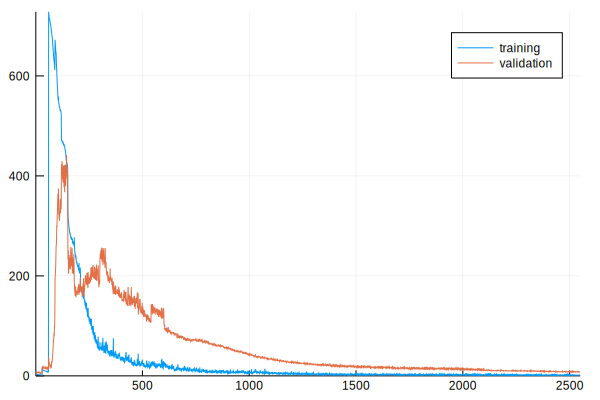

156.061541 seconds (57.91 M allocations: 7.856 GiB, 2.19% gc time)


Progress:  85%|███████████████████████████████████      |  ETA: 4:49:40

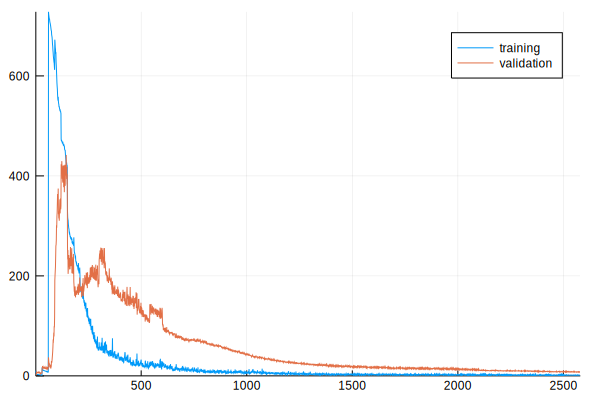

154.963549 seconds (58.61 M allocations: 7.952 GiB, 2.23% gc time)


Progress:  86%|███████████████████████████████████      |  ETA: 4:30:42

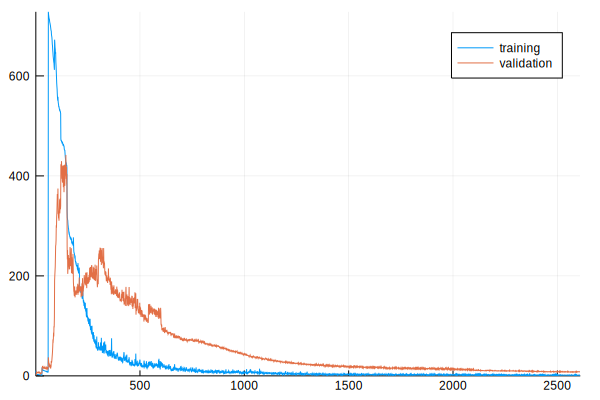

151.822129 seconds (59.28 M allocations: 8.043 GiB, 2.36% gc time)


Progress:  87%|████████████████████████████████████     |  ETA: 4:11:36

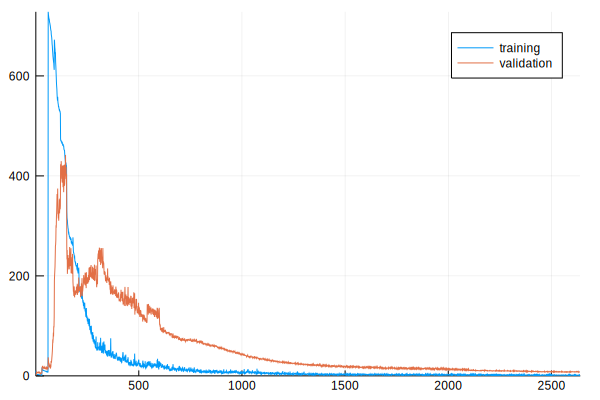

159.475487 seconds (60.09 M allocations: 8.152 GiB, 1.60% gc time)


Progress:  88%|████████████████████████████████████     |  ETA: 3:53:00

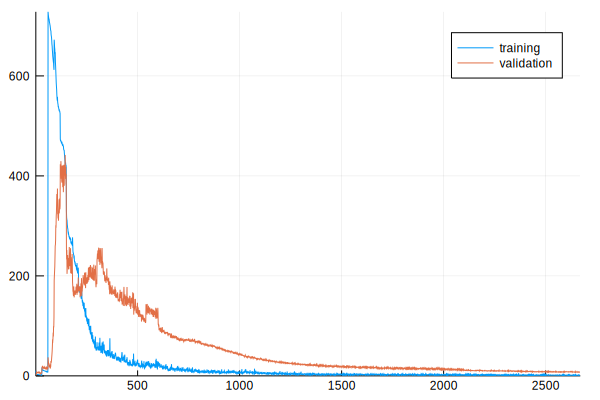

163.370860 seconds (60.81 M allocations: 8.250 GiB, 2.19% gc time)


Progress:  89%|████████████████████████████████████     |  ETA: 3:33:56

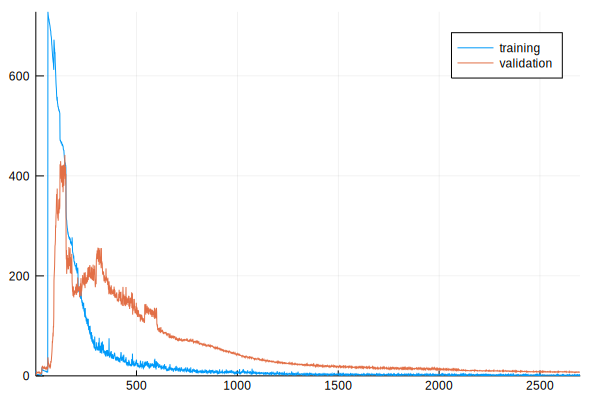

158.274159 seconds (61.63 M allocations: 8.361 GiB, 1.58% gc time)


Progress:  90%|█████████████████████████████████████    |  ETA: 3:14:48

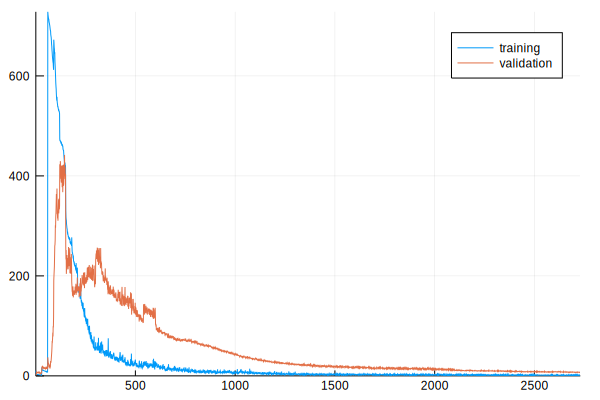

169.128239 seconds (62.27 M allocations: 8.448 GiB, 1.78% gc time)


Progress:  91%|█████████████████████████████████████    |  ETA: 2:55:35

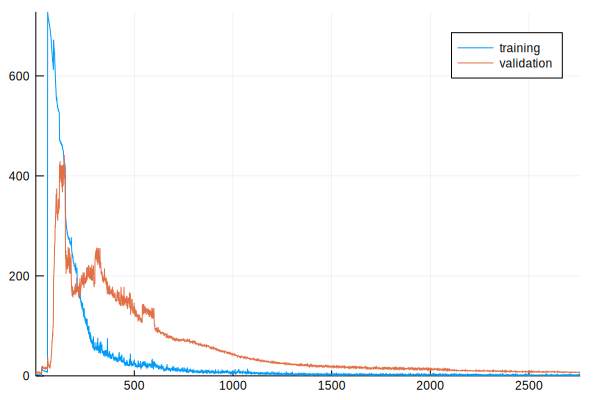

170.763060 seconds (63.02 M allocations: 8.549 GiB, 1.67% gc time)


Progress:  92%|██████████████████████████████████████   |  ETA: 2:36:14

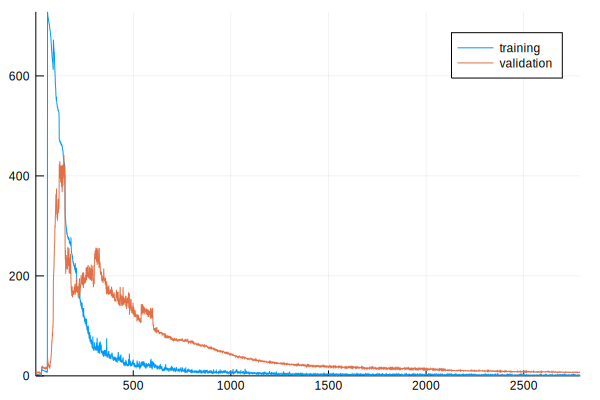

168.969225 seconds (63.74 M allocations: 8.646 GiB, 1.45% gc time)


Progress:  93%|██████████████████████████████████████   |  ETA: 2:16:45

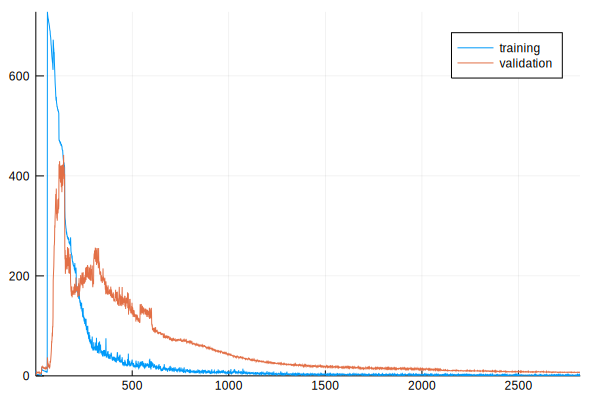

163.010207 seconds (64.24 M allocations: 8.713 GiB, 1.54% gc time)


Progress:  94%|███████████████████████████████████████  |  ETA: 1:57:02

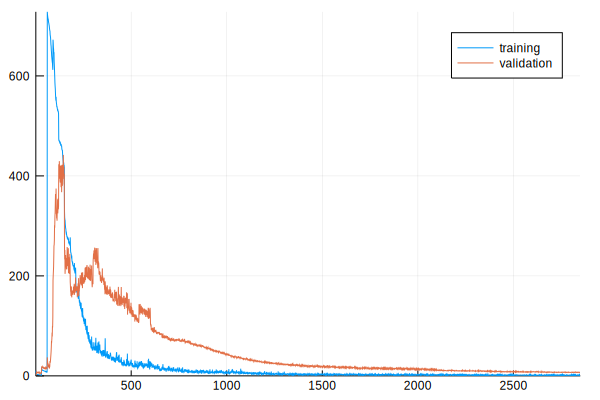

169.940147 seconds (64.91 M allocations: 8.804 GiB, 1.62% gc time)


Progress:  95%|███████████████████████████████████████  |  ETA: 1:37:38

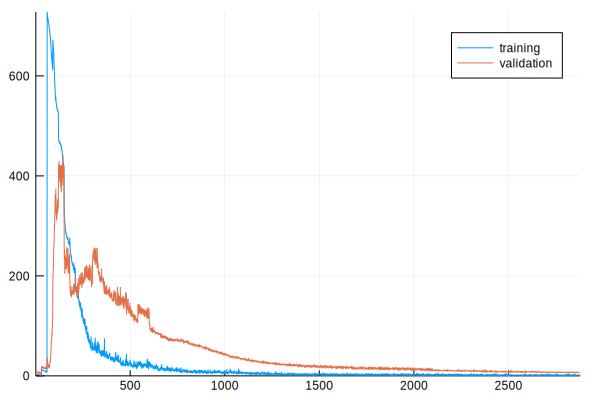

166.186304 seconds (65.66 M allocations: 8.906 GiB, 1.65% gc time)


Progress:  96%|███████████████████████████████████████  |  ETA: 1:18:11

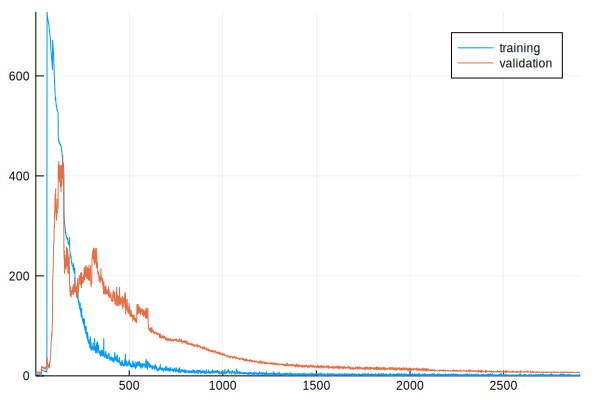

172.408886 seconds (66.29 M allocations: 8.992 GiB, 1.47% gc time)


Progress:  97%|████████████████████████████████████████ |  ETA: 0:58:41

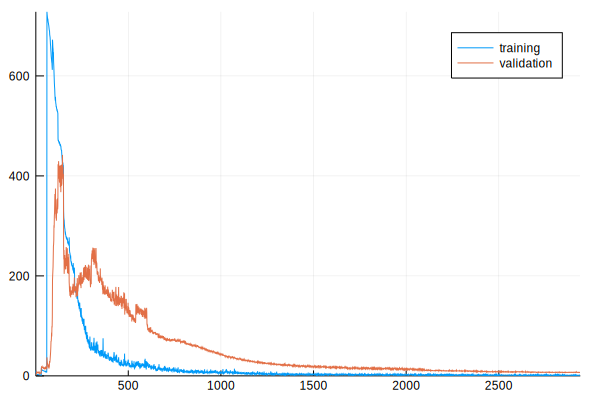

179.616768 seconds (66.98 M allocations: 9.085 GiB, 1.48% gc time)


Progress:  98%|████████████████████████████████████████ |  ETA: 0:39:10

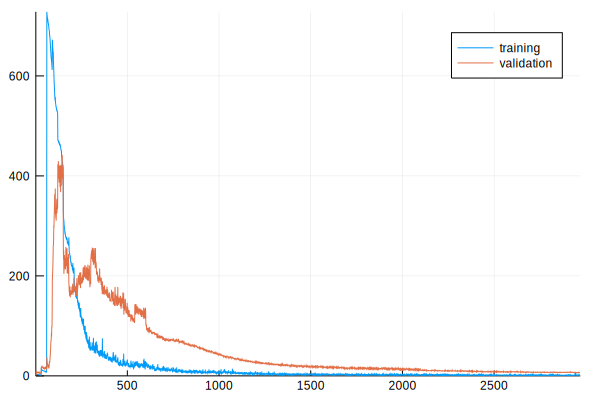

173.500720 seconds (67.52 M allocations: 9.158 GiB, 1.67% gc time)


Progress:  99%|█████████████████████████████████████████|  ETA: 0:19:35

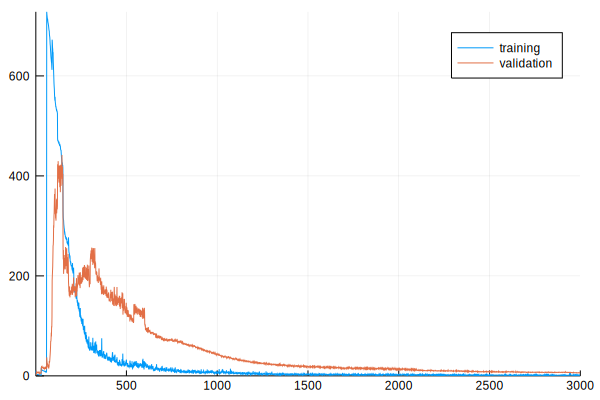

186.906810 seconds (68.20 M allocations: 9.250 GiB, 2.25% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 1 days, 8:38:51


In [6]:
datasets = Vector{LearningMPC.Dataset{Float64}}()
all_training_data = Vector{Tuple{Vector{Float64}, Float64, Float64}}()
all_validation_data = Vector{Tuple{Vector{Float64}, Float64, Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

N_iter = 100
σv = 3.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    for i in 1:2
        collect_into!(dataset.training_data)
    end
    collect_into!(dataset.testing_data, i / N_iter * σv)
    collect_into!(dataset.validation_data, i / N_iter * σv)
    append!(all_training_data, features.(dataset.training_data))
    append!(all_validation_data, features.(dataset.validation_data))
    filter!(all_training_data) do sample
        all(isfinite, sample[1]) && isfinite(sample[2]) && isfinite(sample[3])
    end
    filter!(all_validation_data) do sample
        all(isfinite, sample[1]) && isfinite(sample[2]) && isfinite(sample[3])
    end
    
    @time for i in 1:30
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen("boxatlas.jld2", "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt,
            "horizon" => params.horizon,
        )
        file["all_training_data"] = all_training_data
        file["all_validation_data"] = all_validation_data
        file["losses"] = losses
    end
    
    plt = plot(first.(losses), label="training")
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (0, ylims(plt)[2]))
    display(plt)
end

In [7]:
x0 = nominal_state(robot)
set_velocity!(x0, findjoint(robot.mechanism, "floating_base"), [-2, 0, 0])
results = LCPSim.simulate(x0, net_mpc_controller, environment(robot), 0.01, 300, params.lcp_solver);

In [8]:
set_configuration!(mvis, configuration(results[1].state))

In [9]:
playback(mvis, results, 0.02)